In [4]:
import os 
from glob import glob

import rasterio
from rasterio.mask import mask
from rasterio import plot
#import shapefile
import geopandas as gpd
import fiona as fio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image






In [8]:
#define Image folder path and necessary bands

tallin_bounds_path = 'C:/Users/isaac90/Documents/School/Research/tallinn.shp'

image_path = 'Z:\Isaac\PhD\Tallinn\Level2\LC081890182018072701T1-SC20191119111533'
thermal_path = 'Z:\Isaac\PhD\Tallinn\Level1\LC08_L1TP_189018_20180727_20180731_01_T1'


band4_path =  os.path.join(image_path,'*band4.*')
band5_path = os.path.join(image_path, '*band5.*')
band10_path = os.path.join(thermal_path, '*B10.*')
mtl_path = os.path.join(image_path, '*MTL.*')
atm_params_path = os.path.join(thermal_path,'*atm*')
print(band4_path)

#use glob to fetch the bands
file_band4 =  glob(band4_path)[0].replace('\\','/')
file_band5 =  glob(band5_path)[0].replace('\\','/')
file_band10 =  glob(band10_path)[0].replace('\\','/')
file_mtl =  glob(mtl_path)[0].replace('\\','/')
file_atm_cor_params = glob(atm_params_path)[0].replace('\\','/')

Z:\Isaac\PhD\Tallinn\Level2\LC081890182018072701T1-SC20191119111533\*band4.*


In [9]:
#open tallinn bounds

with fio.open(tallin_bounds_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
#tallinn =  shapefile.Reader(tallin_bounds_path)


#open the bands
band4= rasterio.open(file_band4)
band5= rasterio.open(file_band5)
band10= rasterio.open(file_band10)

#open the Metadata file
mtl= open(file_mtl)

meta=band4.meta

meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 7981,
 'height': 8061,
 'count': 1,
 'crs': CRS.from_epsg(32634),
 'transform': Affine(30.0, 0.0, 526485.0,
        0.0, -30.0, 6785115.0)}

In [ ]:
#clip rasters

#out_image, out_transform = mask(dataset=data2, shapes=shapes, crop=True)
#tal_band4, tal_band4_transform= mask(band4,shapes,crop=True)
#tal_band5, tal_band5_transform= mask(band5,shapes,crop=True)
#tal_band10, tal_band10_transform= mask(band10,shapes,crop=True)


# Remove all occurrences of -9999 - no data.
#tal_band4_1 = tal_band4[tal_band4 != -9999]
#len(tal_band4_1)


#tal_band5_1 = tal_band5[tal_band5 != -9999]
#len(tal_band5_1)

#tal_band10_1 = tal_band10[tal_band10 != 0]
#len(tal_band10_1) 

In [10]:
#calculate NDVI for tallinn
b4=band4.read(1)
b5=band5.read(1)
b10=band10.read(1)

np.seterr(divide='ignore', invalid='ignore')

#ndvi = (b5.astype(float)-b4.astype(float))/(b5+b4)
#ndvi_np = np.divide(np.subtract(b5,b4),np.add(b5,b4)

#plot.show(ndvi)
#ep.plot_bands(ndvi, cmap='PiYG',
#              scale=False,
#             vmin=-1, vmax=1)
#plt.show


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [11]:
meta

# Update meta (change in data type)
meta.update(
    dtype=rasterio.float64)

In [12]:
ndvi_2=np.where(
    (b5-b4)==0., 
    -9999.0, 
    (b5.astype(float)-b4.astype(float))/(b5+b4))


ndvi_2




array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [13]:
with rasterio.open('ndvi_0718.tif', 'w', **meta) as dst:
        dst.write_band(1,ndvi_2)

In [14]:
vegprop_2=np.where(
    ndvi_2==-9999.0, 
    -9999, 
    (ndvi_2-0.2)/(0.5-0.2))

vegprop_2.shape==ndvi_2.shape

True

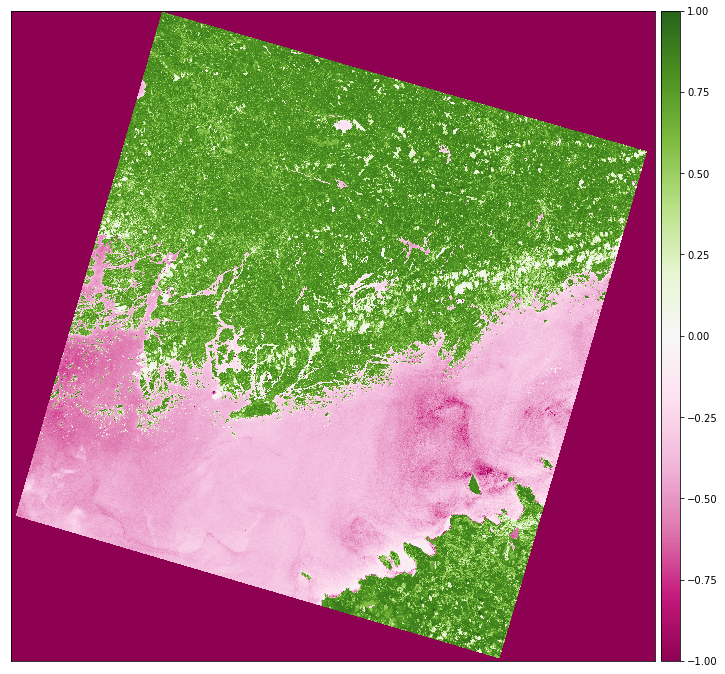

<function matplotlib.pyplot.show(*args, **kw)>

In [15]:
ep.plot_bands(ndvi_2, cmap='PiYG',
              scale=False,
            vmin=-1, vmax=1)
plt.show

In [16]:
emi = []

for pix in range(len(ndvi_2)):
    emrow=[]
    for i in range(len(ndvi_2[pix])):
        if ndvi_2[pix][i] ==-9999.0:
            emrow.append(-9999)
        elif -9999!= ndvi_2[pix][i]<= 0.2:
            emrow.append(0.97)
        elif 0.2<= ndvi_2[pix][i]>= 0.5:
            emrow.append(0.99)
        else:
            emrow.append(0.971*(1-vegprop_2[pix][i])+(0.987*vegprop_2[pix][i]))
    emi.append(emrow)

In [17]:
emiss = np.asarray(emi)

In [18]:
#calculate top of the atmosphere reflectance of the thermal band

toa = (b10.astype(float)*0.0003342)+0.1 #change mult constant if not L8




In [19]:
#calculate top of the atmosphere reflectance of the thermal band and convert to degree cel

bt = (1321.0789 / np.log((774.8853 / toa) + 1)) - 273.15

In [20]:
#calculate delta and gamma


delta = bt - ((bt*bt)/1324)


gamma = (bt*bt)/(1324*toa)



In [21]:
#calcultate atm functions 


atm_params =  open(file_atm_cor_params,'r').read()

atm_params = list()        
with open (file_atm_cor_params, "r") as file:
    for line in file:
        atm_params.append(line.strip()) 
atm_params

transmission = float(atm_params[0][atm_params[0].find(':')+1:].strip())

upwelling_radiance= float(atm_params[1][atm_params[1].find(':')+4:atm_params[1].find('W')-1].
                          strip())

downwelling_radiance= float(atm_params[2][atm_params[2].find(':')+2:atm_params[2].find('W')-1].
                            strip())



w1 = 1/transmission

w2 =(-1*downwelling_radiance) - (upwelling_radiance/transmission)

w3 = downwelling_radiance





print (transmission,upwelling_radiance,downwelling_radiance)

0.65 2.82 4.41


In [ ]:
file_atm_cor_params


In [22]:
#calculate LST


lst = gamma*((((1/np.asarray(emi))*((w1*toa)+w2)) + w3)
           )+delta

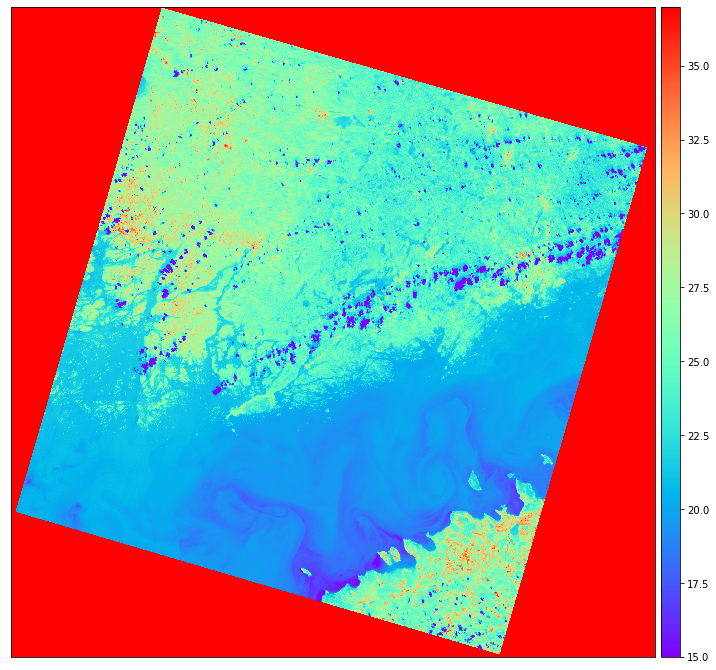

<function matplotlib.pyplot.show(*args, **kw)>

In [23]:
ep.plot_bands(lst, cmap='rainbow',
              scale=False,
            vmin=15, vmax=37)
plt.show

In [24]:
with rasterio.open('lst_0718.tif', 'w', **meta) as dst:
        dst.write_band(1,lst)'fi'

In [ ]:
#lst_r = rasterio.open('lst.tif')
#lst_r.meta

#lst_tal, lsttal_transform= mask(lst_r,shapes,crop=True)

In [ ]:
#lst_n=np.where(
 #   (lst_r)==-9999, 
  #  -0, 
   # lst_r)

In [ ]:
#lst_tmm, lstmm_tal_meta = es.crop_image(lst_n, shapes, all_touched=True)




#ep.plot_bands(lst_n, cmap='RdYlGn',
 #             scale=True,
 #           vmin=35, vmax=38)
#plt.show()
